In [92]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_ollama import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
from contextlib import ExitStack

# Use contextlib to manually enter the context manager and keep the object
stack = ExitStack()
# Create the memory context manager and enter the context
memory= stack.enter_context(SqliteSaver.from_conn_string(":memory:"))

In [93]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [94]:
tool = TavilySearchResults(tavily_api_key = "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", max_results=2)

## Manual human approval

In [95]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [96]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
model = ChatOllama(model = "qwen2.5")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [97]:
messages = [HumanMessage(content="Whats the weather in SF?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33f19565-81ee-4a0f-9509-14a6efcee7a1'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:46:44.873416864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6007707565, 'load_duration': 1583392121, 'prompt_eval_count': 242, 'prompt_eval_duration': 806569094, 'eval_count': 27, 'eval_duration': 3613961514, 'model_name': 'qwen2.5'}, id='run--aa938e64-863e-4637-95c4-abd4dfcf4930-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'a00029d4-4747-4293-8421-e211757ff91b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:46:44.873416864Z', 'done': True, 'done_reason': 'stop', 'total_

In [98]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33f19565-81ee-4a0f-9509-14a6efcee7a1'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:46:44.873416864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6007707565, 'load_duration': 1583392121, 'prompt_eval_count': 242, 'prompt_eval_duration': 806569094, 'eval_count': 27, 'eval_duration': 3613961514, 'model_name': 'qwen2.5'}, id='run--aa938e64-863e-4637-95c4-abd4dfcf4930-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'a00029d4-4747-4293-8421-e211757ff91b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}, next=('action',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b70b-e3f9-6b64-8001-45869e1d985a'}}, metadata={'source': 'loop'

In [99]:
abot.graph.get_state(thread).next

('action',)

## continue after interrupt

In [100]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'a00029d4-4747-4293-8421-e211757ff91b', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Tuesday, June 17, 2025. San Francisco, CA - Weather Forecast\', \'url\': \'https://weathershogun.com/weather/usa/ca/san-francisco/480/june/2025-06-17\', \'content\': \'San Francisco, California Weather: \\n\\nTuesday, June 17, 2025\\n\\nDay 70°\\n\\nNight 55°\\n\\nPrecipitation 0 %\\n\\nWind 12 mph\\n\\nUV Index (0 - 11+)11\\n\\n[Wednesday](https://weathershogun.com/weather/usa/ca/san-francisco/480/june/2025-06-18) [...] Tuesday, June 17, 2025. San Francisco, CA - Weather Forecast \\n\\n===============\\n\\n☰\\n\\n[San Francisco, CA](https://weathershogun.com/weather/usa/ca/san-francisco/today/480)\\n\\n[![Image 1: WeatherShogun.com](https://weathershogun.com/img/logo.svg)](https://weathershogun.com/) [...] [Today](https://weathershogun.com/weather/usa/ca/san

In [101]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in SF?', additional_kwargs={}, response_metadata={}, id='33f19565-81ee-4a0f-9509-14a6efcee7a1'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:46:44.873416864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 6007707565, 'load_duration': 1583392121, 'prompt_eval_count': 242, 'prompt_eval_duration': 806569094, 'eval_count': 27, 'eval_duration': 3613961514, 'model_name': 'qwen2.5'}, id='run--aa938e64-863e-4637-95c4-abd4dfcf4930-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'a00029d4-4747-4293-8421-e211757ff91b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269}), ToolMessage(content='[{\'title\': \'Tuesday, June 17, 2025. San Francisco, CA - Weather Forecast\', \'url\': \'https://weathershogun.com/weather/usa/ca/san-francisco/480

In [102]:
abot.graph.get_state(thread).next

()

In [103]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "2"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print(abot.graph.get_state(thread))
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='1246f458-4a13-4ebb-a198-e543284bc7fd'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:47:07.136793152Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3390218707, 'load_duration': 16957638, 'prompt_eval_count': 242, 'prompt_eval_duration': 218839625, 'eval_count': 26, 'eval_duration': 3150052354, 'model_name': 'qwen2.5'}, id='run--5f6ff417-cf1b-4078-9929-92bde7bed654-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'cc5a9fcb-5bd5-4b2b-bb86-e8d0d7cd62db', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 26, 'total_tokens': 268})]}
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:47:07.136793152Z', 'done': True, 'done_reason': 'stop', 'total_duration': 33

proceed? y


Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in LA'}, 'id': 'cc5a9fcb-5bd5-4b2b-bb86-e8d0d7cd62db', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Weather in Los Angeles in June 2025 (California)\', \'url\': \'https://world-weather.info/forecast/usa/los_angeles/june-2025/\', \'content\': \'*   [17 +86° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-17)\\n*   [18 +86° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-18)\\n*   [19 +82° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-19)\\n*   [20 +84° +66°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-20)\\n*   [21 +86° +75°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-21)\', \'score\': 0.945243}, {\'title\': \'Tuesday, June 17, 2025. Los Angeles, CA - Weather Forecast\', \'url\': \'https://weathershogun.com/weather/usa/ca/los-angeles/451/june

# Modify State

In [104]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}
{'messages': [AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_dura

In [105]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}, next=('action',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1f04b710-e6d8-6f29-8001-69e14081ffb3'}}, metadata={'source': 'loop', 'w

In [106]:
current_values = abot.graph.get_state(thread)

In [107]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})

In [108]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in Los Angeles'},
  'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd',
  'type': 'tool_call'}]

In [109]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
     'args': {'query': 'current weather in Louisiana'},
     'id': _id}
]

In [110]:
print(_id)

89f3b019-7a0c-4dc3-a244-1adf480716dd


In [111]:
abot.graph.update_state(thread, current_values.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}


{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04b710-e777-6147-8002-e92b61cab2d8'}}

In [112]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}, next=('action',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1f04b710-e777-6147-8002-e92b61cab2d8'}}, metadata={'source': 'upd

In [113]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content="[{'title': 'Tuesday, June 17, 2025. New Orleans, LA - Weather Forecast', 'url': 'https://weathershogun.com/weather/usa/la/new-orleans/1865/june/2025-06-17', 'content': 'New Orleans, Louisiana Weather: Tuesday, June 17, 2025. Stormy weather, thunderstorms. Day 88°. Night 77°. Precipitation 70 %. Wind 9 mph.', 'score': 0.9174287}, {'title': 'Tuesday, June 17, 2025. Baton Rouge, LA - Weather Forecast', 'url': 'https://weathershogun.com/weather/usa/la/baton-rouge/1805/june/2025-06-17', 'content': 'Baton Rouge, Louisiana Weather: Tuesday, June 17, 2025. Stormy weather, thunderstorms. Day 90°. Night 75°. Precipitation 55 %. Wind 9 mph.', 'score': 0.9123193}]", name='tavily_search_results_json', id='28dd2bbb-2be7-4356-b475-68843ec2dd3e', tool_call_id='89f3b019-7a0c-4dc3-a244-1

# Time Travel

In [114]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269}), ToolMessage(content="[{'title': 'Tuesday, June 17, 2025. New Orleans, LA - Weather Forecast', 'url': 'https://weathershogun.com/weather/usa/la/new-orleans/1865/june/20

# Now let's see
To fetch the same state as was filmed, the offset below is changed to -3 from -1. This accounts for the initial state __start__ and the first state that are now stored to state memory with the latest version of software.

In [115]:
to_replay = states[-3]

In [116]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}, next=('action',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1f04b710-e6d8-6f29-8001-69e14081ffb3'}}, metadata={'source': 'loop', 'w

In [117]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Weather in Los Angeles in June 2025 (California)\', \'url\': \'https://world-weather.info/forecast/usa/los_angeles/june-2025/\', \'content\': \'*   [17 +86° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-17)\\n*   [18 +86° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-18)\\n*   [19 +82° +64°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-19)\\n*   [20 +84° +66°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-20)\\n*   [21 +86° +75°](https://world-weather.info/forecast/usa/los_angeles/14days/#2025-06-21)\', \'score\': 0.95438045}, {\'title\': \'Tuesday, June 17, 2025. Los Angeles, CA - Weather Forecast\', \'url\': \'https://weathershogun.com/weather/usa/ca/los-angel

## Go back in time and edit

In [118]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}, next=('action',), config={'configurable': {'thread_id': '3', 'checkpoint_ns': '', 'checkpoint_id': '1f04b710-e6d8-6f29-8001-69e14081ffb3'}}, metadata={'source': 'loop', 'w

In [119]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

In [120]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

{'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='893fd179-9aad-423c-86b9-05285327b185'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen2.5', 'created_at': '2025-06-17T11:48:59.392310864Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3876205454, 'load_duration': 11813746, 'prompt_eval_count': 242, 'prompt_eval_duration': 142520091, 'eval_count': 27, 'eval_duration': 3718237787, 'model_name': 'qwen2.5'}, id='run--a314f178-bb72-45f2-8d0e-fdd4ad22b262-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd'}], usage_metadata={'input_tokens': 242, 'output_tokens': 27, 'total_tokens': 269})]}


In [121]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in LA, accuweather'}, 'id': '89f3b019-7a0c-4dc3-a244-1adf480716dd', 'type': 'tool_call'}
Back to the model!
{'messages': [ToolMessage(content='[{\'title\': \'Los Angeles, California, USA 14 day weather forecast - Time and Date\', \'url\': \'https://www.timeanddate.com/weather/usa/los-angeles/ext\', \'content\': \'Jun 17, 84 / 61 °F, Sunny. 82 °F, 9 mph, ↑, 36%, 0%, 0.00", 10 ... * Updated Monday, June 16, 2025 2:24:09 pm Los Angeles time - Weather by CustomWeather, © 2025\', \'score\': 0.7485182}, {\'title\': \'Los Angeles weather with 7-day forecast, Mega Doppler 7000 - ABC7\', \'url\': \'https://abc7.com/weather/\', \'content\': \'AccuWeather · Feels Like. 83°. Sunrise. 5:41 AM · Humidity. 48%. Sunset. 8:06 PM · Windspeed. WSW 3 mph. Moonrise. 11:45 PM · Pressure. 29.88 in. Moonset. 9:39 AM.\', \'score\': 0.6439794}]', name='tavily_search_results_json', id='bbcde6ea-c484-4454-a458-419a1779c012', tool_c

## Close connection

In [122]:
stack.close()

# Extra Practice

## Build a small graph

This is a small simple graph you can tinker with if you want more insight into controlling state memory.

In [7]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver
from contextlib import ExitStack

Define a simple 2 node graph with the following state: -lnode: last node -scratch: a scratchpad location -count : a counter that is incremented each step

In [8]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [9]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
    "count": 1,
           }

def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }
        

The graph goes N1->N2->N1... but break after count reaches 3.

In [10]:
def should_continue(state):
    return state["count"] < 3

In [11]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2",
                              should_continue,
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [12]:
# Use contextlib to manually enter the context manager and keep the object
stack = ExitStack()
# Create the memory context manager and enter the context
memory= stack.enter_context(SqliteSaver.from_conn_string(":memory:"))
graph = builder.compile(checkpointer=memory)

## Runt it

In [131]:
thread = {"configurable": {"thread_id": str(1)}}
graph.invoke({"count": 0, "scratch": "hi"}, thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

## Look at current state
Get the current state. note the values which are the AgentSate. Note the config and the __thread_ts.__ You will be using those to refer to snapshots below.

In [132]:
graph.get_state(thread)

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c277-6cd5-8004-ceee721c7253'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 4, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:02:20.885108+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c276-6269-8003-8249ec3aed2b'}}, tasks=(), interrupts=())

View all the statesnapshots in memory. You can use the displayed `count` agentstate variable to help track what you see. Notice the most recent snapshots are returned by the iterator first. Also note that there is a handy `step` variable in the metadata that counts the number of steps in the graph execution. This is a bit detailed - but you can also notice that the __parent_config__ is the __config__ of the previous node. At initial startup, additional states are inserted into memory to create a parent. This is something to check when you branch or __time travel__ below.

## Look at state history

In [133]:
for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c277-6cd5-8004-ceee721c7253'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 4, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:02:20.885108+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c276-6269-8003-8249ec3aed2b'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c276-6269-8003-8249ec3aed2b'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:02:20.884433+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoin

Store just the `config` into an list. Note the sequence of counts on the right. `get_state_history` returns the most recent snapshots first.

In [134]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c277-6cd5-8004-ceee721c7253'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c276-6269-8003-8249ec3aed2b'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c275-6519-8002-37e8291f4762'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c274-613c-8001-c98b559cacd5'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c272-6ede-8000-92a2c8273faf'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c271-6bbd-bfff-1083f9843ab1'}} 0


In [135]:
states[-3]

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04b72e-c274-613c-8001-c98b559cacd5'}}

This is the state after Node1 completed for the first time, Note `next` is `Node2` and `count` is 1.

In [136]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c274-613c-8001-c98b559cacd5'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 1, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:02:20.883583+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c272-6ede-8000-92a2c8273faf'}}, tasks=(PregelTask(id='d9925201-fd11-d97e-cbb4-dc6a1b0d6554', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

## Go Back in Time
Use that state in `invoke` to go back in time. Notice it uses states[-3] as current_state and continues to node2,

In [137]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [138]:
therad = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6132-60ca-8004-bc9e66763a08'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6131-616d-8003-a6af583d5f04'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6130-61c6-8002-d62e033d53b1'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c277-6cd5-8004-ceee721c7253'}} 4
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c276-6269-8003-8249ec3aed2b'}} 3
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c275-6519-8002-37e8291f4762'}} 2
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c274-613c-8001-c98b559cacd5'}} 1
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b72e-c272-6ede-8000-92a2c8273faf'}} 0
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkp

In [141]:
thread = {"configurable": {"thread_id": str(1)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6132-60ca-8004-bc9e66763a08'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 4, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:11:07.556263+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6131-616d-8003-a6af583d5f04'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f04b742-6131-616d-8003-a6af583d5f04'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 3, 'parents': {}, 'thread_id': '1'}, created_at='2025-06-17T12:11:07.555869+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoin

## Modify State
Let's start by starting a fresh thread and running to clean out history.

In [142]:
thread2 = {"configurable": {"thread_id": str(2)}}
graph.invoke({"count":0, "scratch": "hi"}, thread2)

node1, count:4
node2, count:5


{'lnode': 'node_2', 'scratch': 'hi', 'count': 6}

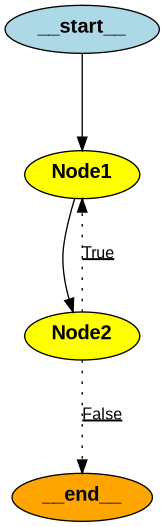

In [143]:
from IPython.display import Image
Image(graph.get_graph().draw_png())

In [144]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d17-6263-8008-b4d48f15ca58'}} 6
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d15-686c-8007-92f35f626c3d'}} 5
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d13-6ec3-8006-43c0ff84a3b6'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d11-6daf-8005-4473fcdf0b4a'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-868a-6075-8004-751dc2792278'}} 4
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8688-659a-8003-a31bdf900a55'}} 3
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8687-6717-8002-6abca0fce543'}} 2
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8685-69b5-8001-8f08a37d4a10'}} 1
{'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkp

In [145]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8685-69b5-8001-8f08a37d4a10'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 1, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:14:46.218583+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8684-629e-8000-17da9ca7526d'}}, tasks=(PregelTask(id='3534bf6f-54cf-7b47-e6bc-a163ad1e13ac', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now modify the values. One subtle item to note: Recall when agent state was defined, `count` used `operator.add` to indicate that values are added to the current value. Here, `-3` will be added to the current count value rather than replace it.

In [146]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8685-69b5-8001-8f08a37d4a10'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 1, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:14:46.218583+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74a-8684-629e-8000-17da9ca7526d'}}, tasks=(PregelTask(id='3534bf6f-54cf-7b47-e6bc-a163ad1e13ac', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now update the state. This creates a new entry at the top, or latest entry in memory. This will become the current state.

In [147]:
graph.update_state(thread2, save_state.values)

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04b757-5ea9-69cf-8009-a7ac1585b269'}}

Current state is at the top. You can match the `thread_ts.` Notice the `parent_config,` `thread_ts` of the new node - it is the previous node.

In [148]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i>=3:
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b757-5ea9-69cf-8009-a7ac1585b269'}}, metadata={'source': 'update', 'writes': {'Node2': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}, 'step': 9, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:20:31.005116+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d17-6263-8008-b4d48f15ca58'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 6}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b74c-2d17-6263-8008-b4d48f15ca58'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 8, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:15:30.528105+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_n

### Try again with `as_node`
When writing using `update_state()`, you want to define to the graph logic which node should be assumed as the writer. What this does is allow th graph logic to find the node on the graph. After writing the values, the `next()` value is computed by travesing the graph using the new state. In this case, the state we have was written by `Node1`. The graph can then compute the next state as being `Node2`. Note that in some graphs, this may involve going through conditional edges!  Let's try this out.

In [149]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '2',
  'checkpoint_ns': '',
  'checkpoint_id': '1f04b75c-2d04-6b21-800a-72a889e21649'}}

In [150]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 0}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b75c-2d04-6b21-800a-72a889e21649'}}, metadata={'source': 'update', 'writes': {'Node1': {'lnode': 'node_1', 'scratch': 'hello', 'count': -3}}, 'step': 10, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:22:40.017271+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b757-5ea9-69cf-8009-a7ac1585b269'}}, tasks=(PregelTask(id='16287039-9acf-a3cb-69dd-28efa0578a98', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b757-5ea9-69cf-8009-a7ac1585b269'}}, metadata={'source': 'update', 'writes': {'Node2': {'lnode': 'node_1', 's

In [151]:
graph.invoke(None,thread2)

node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

In [152]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b75e-fefb-6833-800d-a7a825996016'}}, metadata={'source': 'loop', 'writes': {'Node2': {'lnode': 'node_2', 'count': 1}}, 'step': 13, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:23:55.720702+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b75e-fefa-6614-800c-6a459be0572f'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'checkpoint_id': '1f04b75e-fefa-6614-800c-6a459be0572f'}}, metadata={'source': 'loop', 'writes': {'Node1': {'lnode': 'node_1', 'count': 1}}, 'step': 12, 'parents': {}, 'thread_id': '2'}, created_at='2025-06-17T12:23:55.720236+00:00', parent_config={'configurable': {'thread_id': '2', 'checkpoint_ns': '', 'c

## Close connection

In [14]:
stack.close()